# Tarefa 03
---
A terceira tarefa consiste na transformação de dados disponíveis em arquivo Json para o formato de dataframe, algo comum no dia a dia da empresa. Após transformar esse Json em dataframe é possível perceber que a coluna "item_list" está como dicionário. Seu gestor pediu dois pontos de atenção nessa tarefa:

Resolução de problema de transformação de dados (NF-e):
- Expandir a coluna num mesmo dataframe
- Normalizar os itens dessa coluna de dicionário e dividí-los em dois dataframes separados, seguindo o modelo relacional.

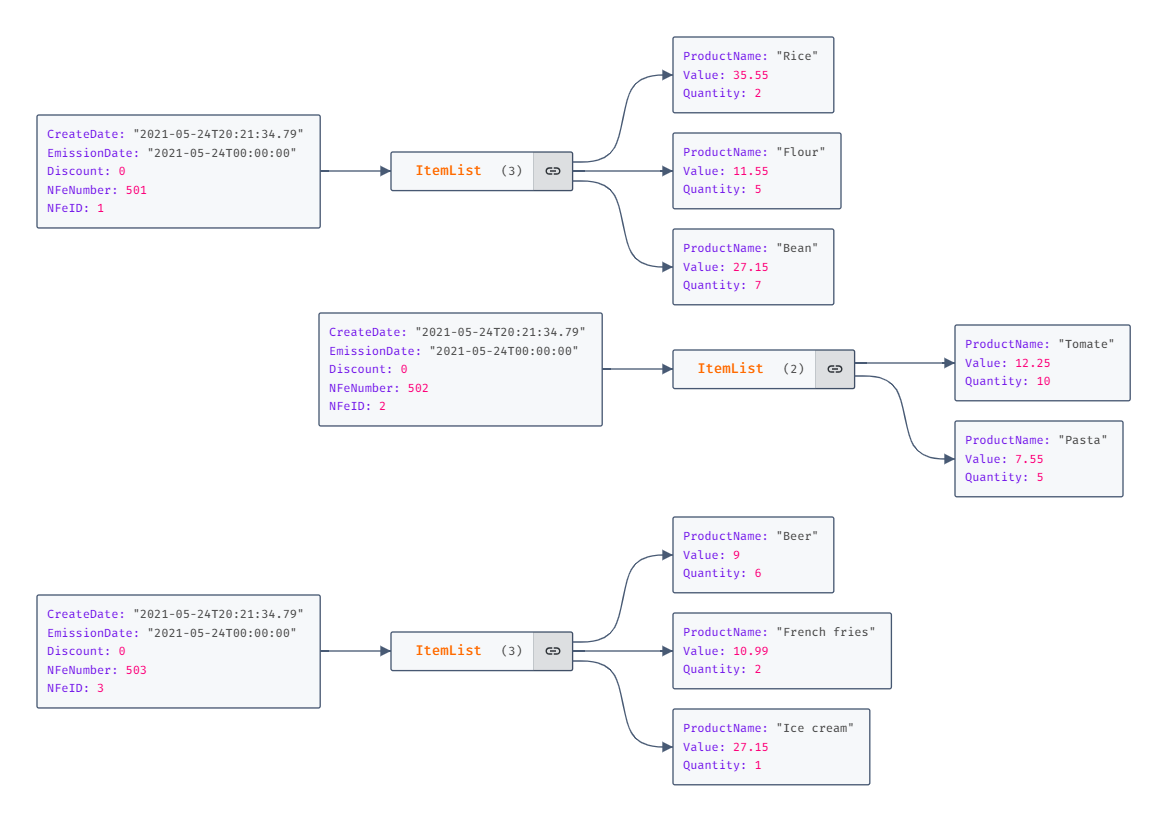.

## Resolução
---

Para essa tarefa iremos utilizar o Pyspark SQL.

#### Criando sessão do spark:

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder\
                    .appName('resolucao_tarefa_03')\
                    .getOrCreate()

23/10/31 09:41:53 WARN Utils: Your hostname, NBKPE08TCSB resolves to a loopback address: 127.0.1.1; using 172.29.120.13 instead (on interface eth0)
23/10/31 09:41:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/31 09:41:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Carregando dados json para Dataframe

In [2]:
df = spark.read.option("multiline", "true").json("./data.json")

##### Verificando o schema dos dados

In [3]:
df.printSchema()

root
 |-- CreateDate: string (nullable = true)
 |-- Discount: double (nullable = true)
 |-- EmissionDate: string (nullable = true)
 |-- ItemList: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ProductName: string (nullable = true)
 |    |    |-- Quantity: long (nullable = true)
 |    |    |-- Value: double (nullable = true)
 |-- NFeID: long (nullable = true)
 |-- NFeNumber: long (nullable = true)



#### Expandindo os dados do dicionário ItemList para colunas

In [4]:
df = df.withColumn('ItemList', F.explode('ItemList')).select('ItemList.*', '*').drop('ItemList')
df.show()

+------------+--------+-----+--------------------+--------+-------------------+-----+---------+
| ProductName|Quantity|Value|          CreateDate|Discount|       EmissionDate|NFeID|NFeNumber|
+------------+--------+-----+--------------------+--------+-------------------+-----+---------+
|        Rice|       2|35.55|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    1|      501|
|       Flour|       5|11.55|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    1|      501|
|        Bean|       7|27.15|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    1|      501|
|      Tomate|      10|12.25|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    2|      502|
|       Pasta|       5| 7.55|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    2|      502|
|        Beer|       6|  9.0|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    3|      503|
|French fries|       2|10.99|2021-05-24T20:21:...|     0.0|2021-05-24T00:00:00|    3|      503|
|   Ice cream|       1|27.15|2021-05-24T

#### Criando o dataframe de notas fiscais

Adicionalmente aplicamos um padrão para a nomenclatura das colunas

In [12]:
df_nota_fiscal = df.select('NFeID', 'NFeNumber', 'CreateDate', 'EmissionDate').distinct()\
                    .withColumnRenamed('NFeID', 'nfe_id')\
                    .withColumnRenamed('NFeNumber', 'nfe_number')\
                    .withColumnRenamed('CreateDate', 'nfe_create_date')\
                    .withColumnRenamed('EmissionDate', 'nfe_emission_date')

df_nota_fiscal.show()

+------+----------+--------------------+-------------------+
|nfe_id|nfe_number|     nfe_create_date|  nfe_emission_date|
+------+----------+--------------------+-------------------+
|     3|       503|2021-05-24T20:21:...|2021-05-24T00:00:00|
|     2|       502|2021-05-24T20:21:...|2021-05-24T00:00:00|
|     1|       501|2021-05-24T20:21:...|2021-05-24T00:00:00|
+------+----------+--------------------+-------------------+



#### Criando o dataframe dos itens da notas

Mantemos o id da nota fiscal para obter o relacionamento entre a tabelas.<br>
Adicionalmente criamos uma chave primária para a tabela (`item_id`) e um id para cada linha de item (`product_line`), permitindo assim um controle de qualidade e deduplicidade no dados, caso necessário.

In [11]:
df_produtos = df.withColumn('product_line', F.row_number().over(Window.partitionBy('NFeNumber').orderBy(F.asc('CreateDate'))))\
                    .withColumn('item_id', F.row_number().over(Window.partitionBy(F.lit('')).orderBy(F.asc('CreateDate'))))\
                    .select('item_id', 'NFeID', 'product_line', 'ProductName', 'Quantity', 'Value', 'Discount')\
                    .withColumnRenamed('NFeID', 'nfe_id')\
                    .withColumnRenamed('ProductName', 'product_name')\
                    .withColumnRenamed('Quantity', 'product_quantity')\
                    .withColumnRenamed('Value', 'product_value')\
                    .withColumnRenamed('Discount', 'product_discount')

df_produtos.show()

+-------+------+------------+------------+----------------+-------------+----------------+
|item_id|nfe_id|product_line|product_name|product_quantity|product_value|product_discount|
+-------+------+------------+------------+----------------+-------------+----------------+
|      1|     1|           1|        Rice|               2|        35.55|             0.0|
|      2|     1|           2|       Flour|               5|        11.55|             0.0|
|      3|     1|           3|        Bean|               7|        27.15|             0.0|
|      4|     2|           1|      Tomate|              10|        12.25|             0.0|
|      5|     2|           2|       Pasta|               5|         7.55|             0.0|
|      6|     3|           1|        Beer|               6|          9.0|             0.0|
|      7|     3|           2|French fries|               2|        10.99|             0.0|
|      8|     3|           3|   Ice cream|               1|        27.15|             0.0|